In [8]:
from devito import *
from AI4Advection_Diffusion import AI4Advection_Difussion
from examples.cfd import  plot_field
import numpy as np
import torch
import matplotlib.pyplot as plt

torch.Size([1, 1, 64, 64])


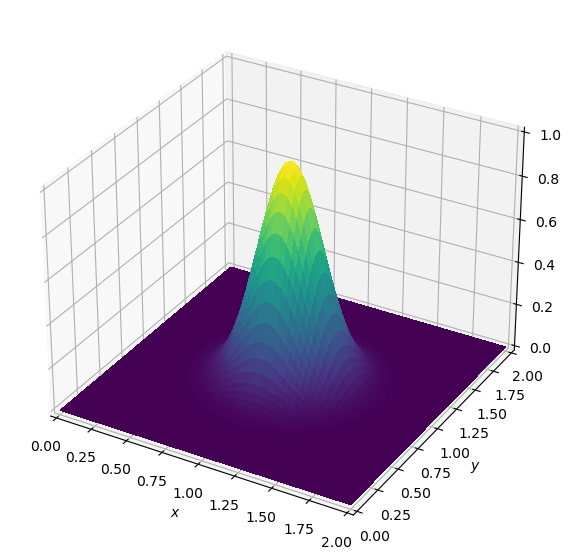

In [56]:

def init_smooth(field, dx, dy):
    nx, ny = field.shape
    x = np.linspace(0, (nx-1)*dx, nx)
    y = np.linspace(0, (ny-1)*dy, ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    # 使用高斯分布初始化平滑场
    sigma = 0.2
    field[:] = np.exp(-((X-nx*dx/2)**2 + (Y-ny*dy/2)**2) / (2*sigma**2))
    
nt = 100  # Number of timesteps
dt = 0.01  # Timestep size (sigma=0.2)
nx = 64
ny = 64
length = 2.
c = 1  # Value for c

# Then we create a grid and our function
grid = Grid(shape=(nx, ny), extent=(length, length))
u = TimeFunction(name='u', grid=grid,save = nt,time_order = 2, space_order = 2)
# We can now set the initial condition and plot it
init_smooth(field=u.data[0], dx=grid.spacing[0], dy=grid.spacing[1])
u_tensor_init_ad = torch.tensor(u.data[0], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
torch.save(u_tensor_init_ad[0,0,:,:].detach(),f'./advection_equation_result/AD0.pt')
print(u_tensor_init_ad.shape)
plot_field(u.data[0])



In [69]:
u_tensor = u_tensor_init_ad
for i in range(1,nt):
    model_adv = AI4Advection_Difussion(u = u_tensor, dx = length/nx, dy = length/ny, cx = 5, cy = 5, nx = nx, ny = ny,dt = dt, Dx = 2, Dy = 2)
    result = model_adv.forward(5)
    u_tensor = result
    torch.save(u_tensor[0,0,:,:].detach(),f'./advection_equation_result/AD{i}.pt')

tensor([[[[0.0299, 0.0315, 0.0343,  ..., 0.0355, 0.0328, 0.0311],
          [0.0315, 0.0332, 0.0360,  ..., 0.0372, 0.0345, 0.0328],
          [0.0343, 0.0360, 0.0389,  ..., 0.0402, 0.0374, 0.0356],
          ...,
          [0.0355, 0.0372, 0.0402,  ..., 0.0415, 0.0386, 0.0368],
          [0.0328, 0.0345, 0.0374,  ..., 0.0386, 0.0358, 0.0341],
          [0.0311, 0.0328, 0.0356,  ..., 0.0368, 0.0341, 0.0323]]]],
       grad_fn=<AddBackward0>)
tensor([[[[0.0362, 0.0379, 0.0409,  ..., 0.0439, 0.0409, 0.0391],
          [0.0379, 0.0397, 0.0427,  ..., 0.0457, 0.0428, 0.0409],
          [0.0409, 0.0427, 0.0458,  ..., 0.0490, 0.0460, 0.0441],
          ...,
          [0.0439, 0.0457, 0.0490,  ..., 0.0523, 0.0492, 0.0472],
          [0.0409, 0.0428, 0.0460,  ..., 0.0492, 0.0460, 0.0441],
          [0.0391, 0.0409, 0.0441,  ..., 0.0472, 0.0441, 0.0422]]]],
       grad_fn=<AddBackward0>)
tensor([[[[-0.0064, -0.0082, -0.0111,  ..., -0.0084, -0.0057, -0.0040],
          [-0.0082, -0.0099, -0.0129, 

tensor([[[[ 2854763.5000,  2889952.7500,  2953698.5000,  ...,
            6051170.5000,  5948385.0000,  5885729.5000],
          [ 2889952.5000,  2925350.0000,  2989544.7500,  ...,
            6125085.5000,  6021607.0000,  5958593.5000],
          [ 2953698.2500,  2989544.7500,  3054808.7500,  ...,
            6259789.0000,  6154602.5000,  6090802.0000],
          ...,
          [ 6051170.5000,  6125085.5000,  6259788.5000,  ...,
           14181784.0000, 13953164.0000, 13813918.0000],
          [ 5948385.0000,  6021606.0000,  6154602.0000,  ...,
           13953165.0000, 13727362.0000, 13589374.0000],
          [ 5885728.5000,  5958593.0000,  6090801.0000,  ...,
           13813917.0000, 13589374.0000, 13452017.0000]]]],
       grad_fn=<AddBackward0>)
tensor([[[[ 3602857.2500,  3647256.7500,  3727685.7500,  ...,
            7639443.5000,  7509817.5000,  7430792.0000],
          [ 3647256.5000,  3691918.7500,  3772914.0000,  ...,
            7732677.5000,  7602177.5000,  7522702.0000],

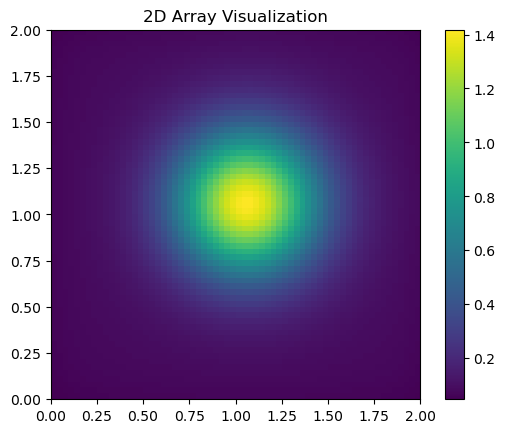

In [70]:
import matplotlib.pyplot as plt
test = torch.load('./advection_equation_result/AD4.pt')

plt.imshow(test.numpy(), extent=(0, 2, 0, 2), origin='lower', cmap='viridis')
plt.colorbar()  
plt.title("2D Array Visualization")
plt.show()

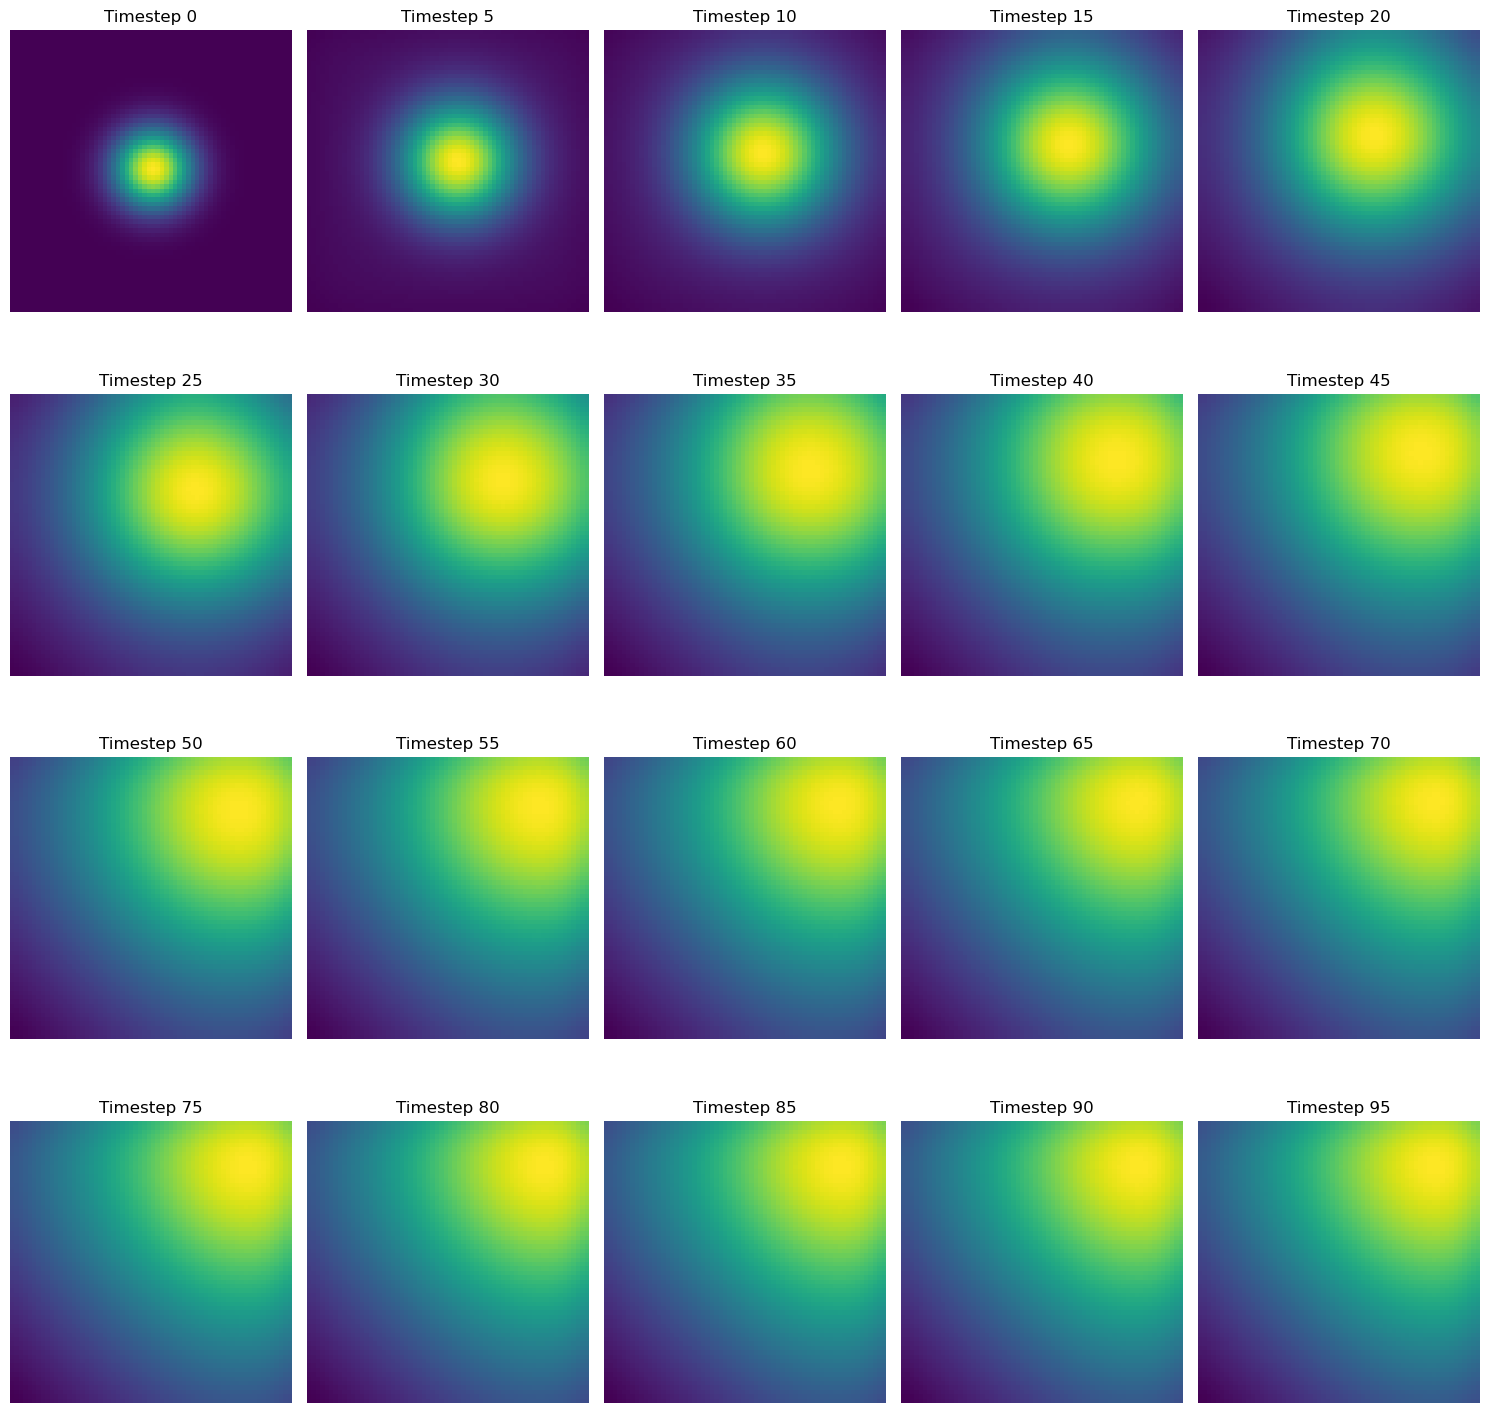

In [71]:
tensors = []
for i in range(0, nt, 5):
    tensor = torch.load(f'./advection_equation_result/AD{i}.pt')
    tensors.append(tensor)

fig, axes = plt.subplots(nrows=len(tensors)//5, ncols=5, figsize=(15, 15))

for idx, tensor in enumerate(tensors):
    ax = axes[idx // 5, idx % 5]
    data = tensor.detach().numpy()
    ax.imshow(data, cmap='viridis', origin='lower')
    ax.set_title(f'Timestep {idx*5}')
    ax.axis('off')  

plt.tight_layout()
plt.show()

In [72]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# 加载张量数据
tensors = []
for i in range(1, nt):
    tensor = torch.load(f'./advection_equation_result/AD{i}.pt')
    tensors.append(tensor)

# 创建动画
fig, ax = plt.subplots()
def update(frame):
    global cbar
    ax.clear()
    data = tensors[frame].detach().numpy()
    cax = ax.imshow(data, cmap='viridis', origin='lower',extent=(0,2,0,2))
    ax.set_title(f'Timestep {frame}')
    return cax

anim = FuncAnimation(fig, update, frames=len(tensors), interval=200, blit=False)

# 显示动画
plt.close(fig)  # 防止显示静态图
HTML(anim.to_jshtml())